# **Проект 4. Компьютер говорит "нет"**
Задача - построить модель для предсказания дефолта.

**Описания полей**

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

# Imports

In [1]:
from pandas import Series
import numpy as np
import pandas as pd
import pandas_profiling

import operator
import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler, RobustScaler, OrdinalEncoder, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.model_selection import StratifiedKFold, cross_val_score , train_test_split, GridSearchCV,RandomizedSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from catboost import CatBoost,CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
import lightgbm
from xgboost import XGBClassifier
import pickle

from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
import plotly.express as px
import datatable as dt
from sklearn import metrics
import itertools

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score,plot_roc_curve
from sklearn.metrics import classification_report, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from datetime import date
from datetime import datetime, timedelta

import warnings; warnings.simplefilter('ignore') # Убирает некритические сообщения
RANDOM_SEED = 42                                 # Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt                   # Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы

In [2]:
lbl = LabelEncoder()

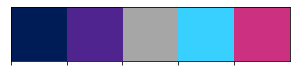

In [3]:
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

# Functions

In [4]:
def prepare_data(df):
    #df = df.drop('client_id', axis=1)
    # Т.к. в education отсутствует только 0.4% строк, заполним самой частой - SCH
    edu_mode = df.education.mode()[0]
    df.education.fillna(edu_mode, inplace=True)
    
    global bin_cols
    global cat_cols
    global num_cols
    
    # переведём формат в дату
    df.app_date = pd.to_datetime(df.app_date)
    
    return df

In [5]:
def feat_eng(df):
    
    global bin_cols
    global cat_cols
    global num_cols
    df['month'] = df.app_date.dt.month
    df = df.drop(['app_date'], axis=1)
    # 0 - нет машины, 1 - есть машина, 2 - есть иномарка
    df['car_combined'] = df['car'] + df['car_type']
    df = df.drop(['car', 'car_type'], axis=1)
    
    bin_cols = list(set(bin_cols) - set(['car', 'car_type']))
    cat_cols.append('car_combined')
    
    # добавим новую колонку, удалим старую
    df['age_cat'] = df.age.apply(age_cat)
    df = df.drop('age', axis=1)
    
    num_cols.remove('age')
    cat_cols.append('age_cat')
    
    address = df[['work_address', 'home_address']].values

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(address)

    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    df['address'] = pca_data
    
    df = df.drop(['work_address', 'home_address'], axis=1)
    cat_cols.remove('work_address')
    cat_cols.remove('home_address')
    num_cols.append('address')
    
    return df

In [6]:
def dummy_and_standard(df):
    global bin_cols
    global cat_cols
    global num_cols
    
    # закодируем бинарные и категориальные признаки
    for col in (bin_cols+cat_cols):
        df[col] = lbl.fit_transform(df[col])
        
    # Стандартизируем числовые признаки
    X_num = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = X_num
    
    # создадим dummy-переменные для категориальных признаков
    X_cat = pd.get_dummies(df[cat_cols], columns=cat_cols)
    df = df.drop(cat_cols, axis=1).join(X_cat)
    return df

In [7]:
def encoder(df, cols):
    for i in cols:
        df[i] = lbl.fit_transform(df[i])
    return df

In [8]:
def barh_plot(df, cols):
    imp = pd.Series(f_classif(df[cols], df['default'])[0], index=cols)
    imp.sort_values(inplace=True)
    imp.plot(kind='barh')
    plt.show()

In [9]:
def corr_matrix(data, det=True, pltx=10, plty=10):
    '''Funcion is called for making correlation matrix'''
    
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinant of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [10]:
def boxplot(data, col1, col2):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=col1, y=col2, data=data,ax=axes)
    axes.set_title(f'Boxplot for {col1} and {col2}')
    plt.show()
    


In [11]:
# разобьём на 4 категории
def age_cat(age):
    if age < 26:
        age_cat = 'young'
        return age_cat             
    if 26 <= age <= 35:
        age_cat = 'adult'
        return age_cat
    if 35 < age < 50:
        age_cat = 'middle'
        return age_cat
    if age >= 50:
        age_cat = 'senior'
        return age_cat

In [12]:
def find_outliers(data):
    '''Find outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    bot = q1 - (1.5 * IQR)
    top = q3 + (1.5 * IQR)
    count = len(data[data < bot]) + len(data[data > top])

    print(f'Bot: {round(bot,3)}, Top: {round(top,3)}, Outliers: {count}')

In [13]:
def num_vis(col, title=None):
    '''Визуализировать числовые признаки'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=True, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2)
    sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')

    plt.show()

In [14]:
def make_confusion_matrix(cf,
                          group_names=['TN', 'FP', 'FN', 'TP'],
                          categories='auto',
                          sum_stats=True,
                          count=True,
                          cbar=True,
                          percent=True,
                          cmap='BuPu'):
    '''Function is called for making a confusion matrix
    args
    ------
    cf - confusion matrix
    group_names - Names for each group
    categories -  categories to be displayed on the x,y axis. Default is 'auto'
    sum_stats -   shows Accuracies. Deafult is TRUE
    c_bar -       If True, show the color bar. The cbar values are based off the values in the confusion matrix. 
                  Default is True
    percent -     to be displayed on the x,y axis. Default is True
    '''
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [
            "{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)
        ]
    else:
        group_percentages = blanks

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Metrics
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5 * (cf[1, 1] / sum(cf[1, :]) +
                              cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cf,
                annot=box_labels,
                fmt="",
                cmap=cmap,
                cbar=cbar,
                xticklabels=categories,
                yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

In [15]:
def make_roc_auc(model, X_test, y_test):
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [16]:
def refresh_features():
    global bin_cols
    global cat_cols
    global num_cols
    bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
    cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
    num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

In [17]:
def run_log_r(X, y, penalty='l2', C=1.):
    '''LogisticRegression'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)
    model = LogisticRegression(random_state=RANDOM_SEED, penalty=penalty, C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    make_roc_auc(model, X_test, y_test)
    cf = confusion_matrix(y_test, y_pred)
    make_confusion_matrix(cf)
    
    return model, y_pred

In [18]:
def run_rand_forest(X, y, n_estimators=100, max_depth=None, max_features='auto'):
    '''RandomForestClassifier'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)
    model = RandomForestClassifier(random_state=RANDOM_SEED, 
        n_estimators=n_estimators,
        max_depth=max_depth, 
        max_features=max_features
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    make_roc_auc(model, X_test, y_test)
    cf = confusion_matrix(y_test, y_pred)
    make_confusion_matrix(cf)
    
    return model, y_pred

In [19]:
def fill_report(name, model, X, y):
    '''Для добавления результата модели в df'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.2)
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    temp_df = pd.DataFrame({
        'model': name,
        'roc_auc': roc_auc,
        'f1_score': f1_score(y_test, model.predict(X_test))
    }, index=[0])
    global report_df
    temp_df = report_df.append(temp_df)
    return temp_df

# Upload

In [20]:
folder = 'C:/Users/serge/Downloads/sf-dst-scoring/'
train = pd.read_csv(folder + 'train.csv')
test = pd.read_csv(folder + 'test.csv')
sample = pd.read_csv(folder + 'sample_submission.csv')

In [21]:
train['sample'] = 1   
test['sample'] = 0
test['default'] = -1  
data = train.append(test, sort=False).reset_index(drop=True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

# Первичный анализ

In [23]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* 7 числовый, 10 категориальных и 3 Boolean
* нет дубликатов
* Есть пропуски только в одном признаке - education
* Нет корреляции с целевой переменной
* Есть корреляция между home_address и work_address, income и region_rating, first_time и sna
* Распределение у age, decline_app_cnt, bki_request_cnt, income имеют хвост справа

# Анализ признаков

In [24]:
# обнулить cat_cols, bin_col, num_cols
refresh_features()

In [25]:
train = prepare_data(train)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73799 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

__Числовые признаки__

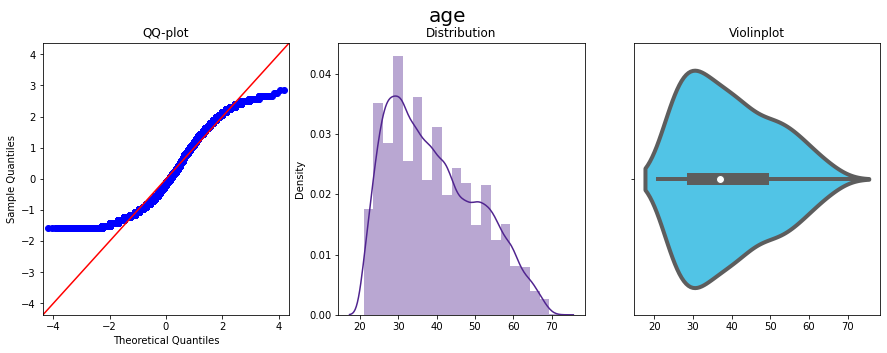

Bot: 3.0, Top: 75.0, Outliers: 0


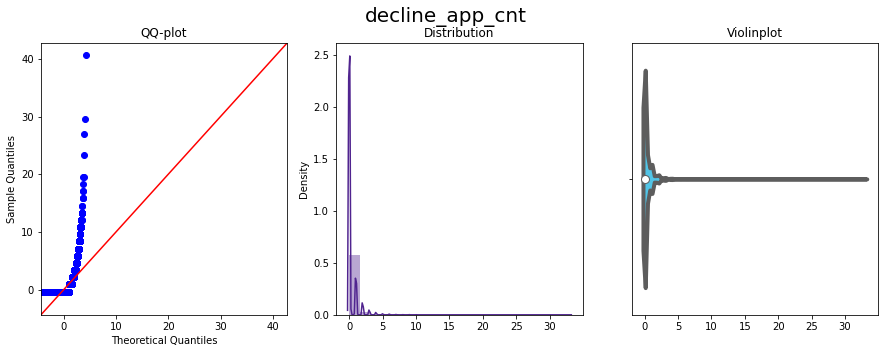

Bot: 0.0, Top: 0.0, Outliers: 12585


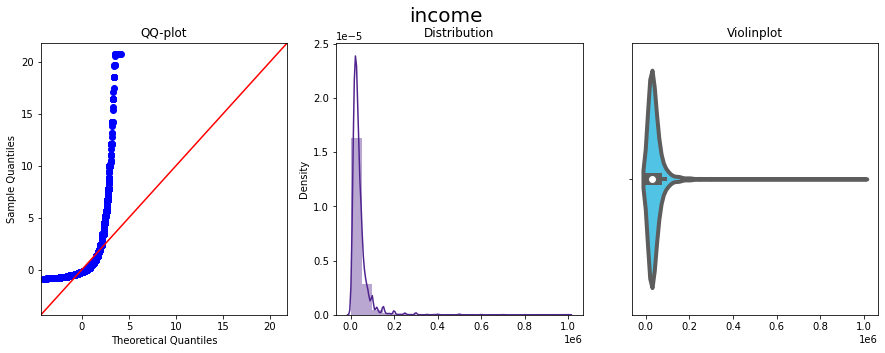

Bot: -22000.0, Top: 90000.0, Outliers: 4695


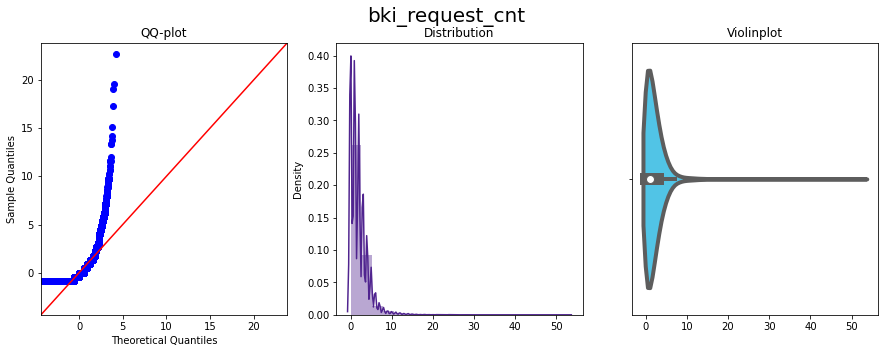

Bot: -4.5, Top: 7.5, Outliers: 1755


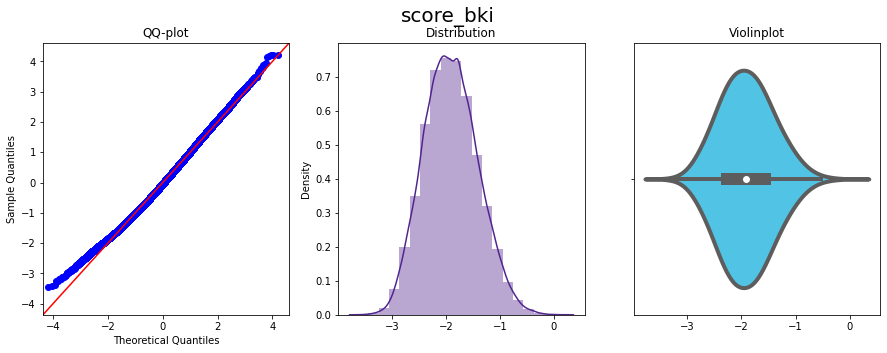

Bot: -3.294, Top: -0.535, Outliers: 351


In [27]:
for col in num_cols:
    num_vis(train[col], title=col)
    find_outliers(train[col])

Нормальное распределение только у score_bki, в остальных случаях хвост справа. Имеются выбросы, но пока не совсем понятно что с ними сделать.

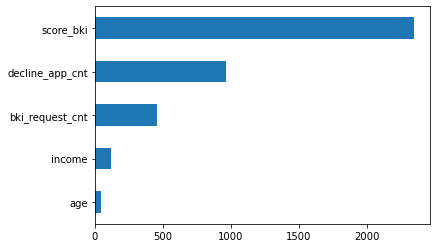

In [28]:
barh_plot(train, num_cols)

Rank of Matrix: 5
Determinant of matrix: 0.8922
Shape of matrix: (5, 5)


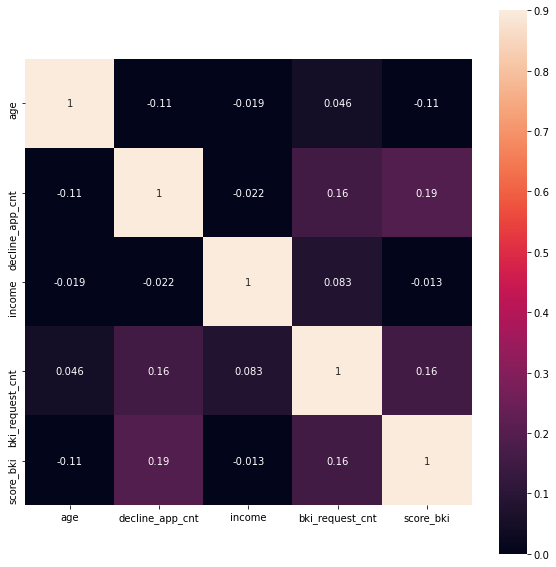

In [29]:
corr_matrix(train[num_cols])

Практически нет корреляции между числовыми признаками. Самая высокая корреляция между decline_app_cnt и score_bki

__Бинарные признаки__


In [285]:
train = encoder(train,bin_cols)

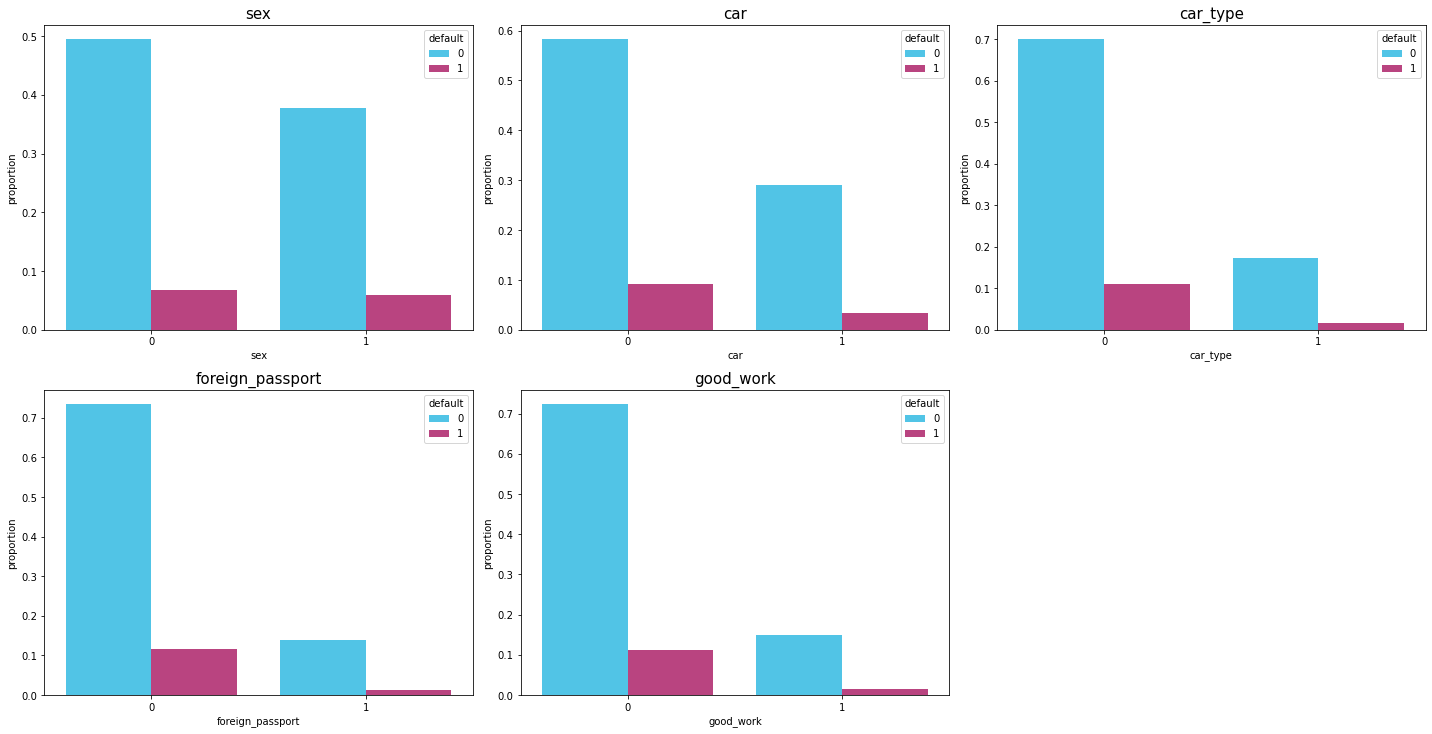

In [286]:
plt.figure(figsize=[20, 20])
i = 1

for k in bin_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=train[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index(),
                palette=[colors[3], colors[4]])
    plt.title(k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [287]:
for i in bin_cols:
    print(round(train.groupby([i]).default.value_counts(normalize=True),3))
    print()

sex  default
0    0          0.879
     1          0.121
1    0          0.866
     1          0.134
Name: default, dtype: float64

car  default
0    0          0.863
     1          0.137
1    0          0.894
     1          0.106
Name: default, dtype: float64

car_type  default
0         0          0.864
          1          0.136
1         0          0.913
          1          0.087
Name: default, dtype: float64

foreign_passport  default
0                 0          0.864
                  1          0.136
1                 0          0.926
                  1          0.074
Name: default, dtype: float64

good_work  default
0          0          0.867
           1          0.133
1          0          0.905
           1          0.095
Name: default, dtype: float64



Выводы по бинарным признакам:
* Женщины чуть реже попадают в дефолт (0.9%, если брать в пропорциях)
* Владельцы машины также реже попадают в дефолт, а владельцы иномарки ещё реже, но чтобы увидеть полную картину хорошо было бы объединить эти два признака, чтобы получилось 3 - есть машина, нет машины, иномарка
* Наличие загран пасспорта также свидетельствует о более надёжном клиенте
* "Хорошая" работа также позволяет реже попадать в дефолт

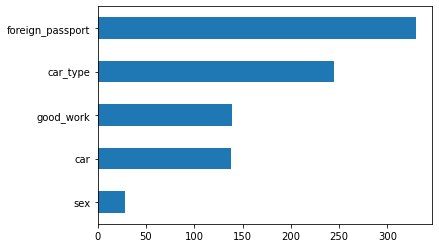

In [288]:
# проверим наиболее значимые признаки
barh_plot(train, bin_cols)

Rank of Matrix: 5
Determinant of matrix: 0.4583
Shape of matrix: (5, 5)


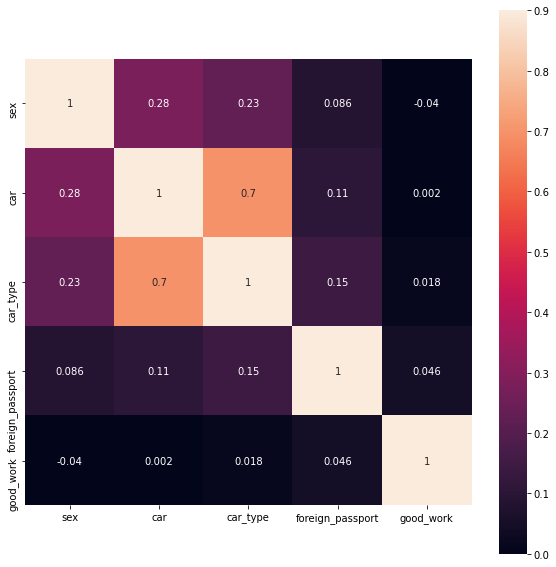

In [289]:
corr_matrix(train[bin_cols])

Видна сильная корреляция между наличием машины и наличием иномарки.***Необходимо будет объединить эти признаки.***

**Категориальные признаки**

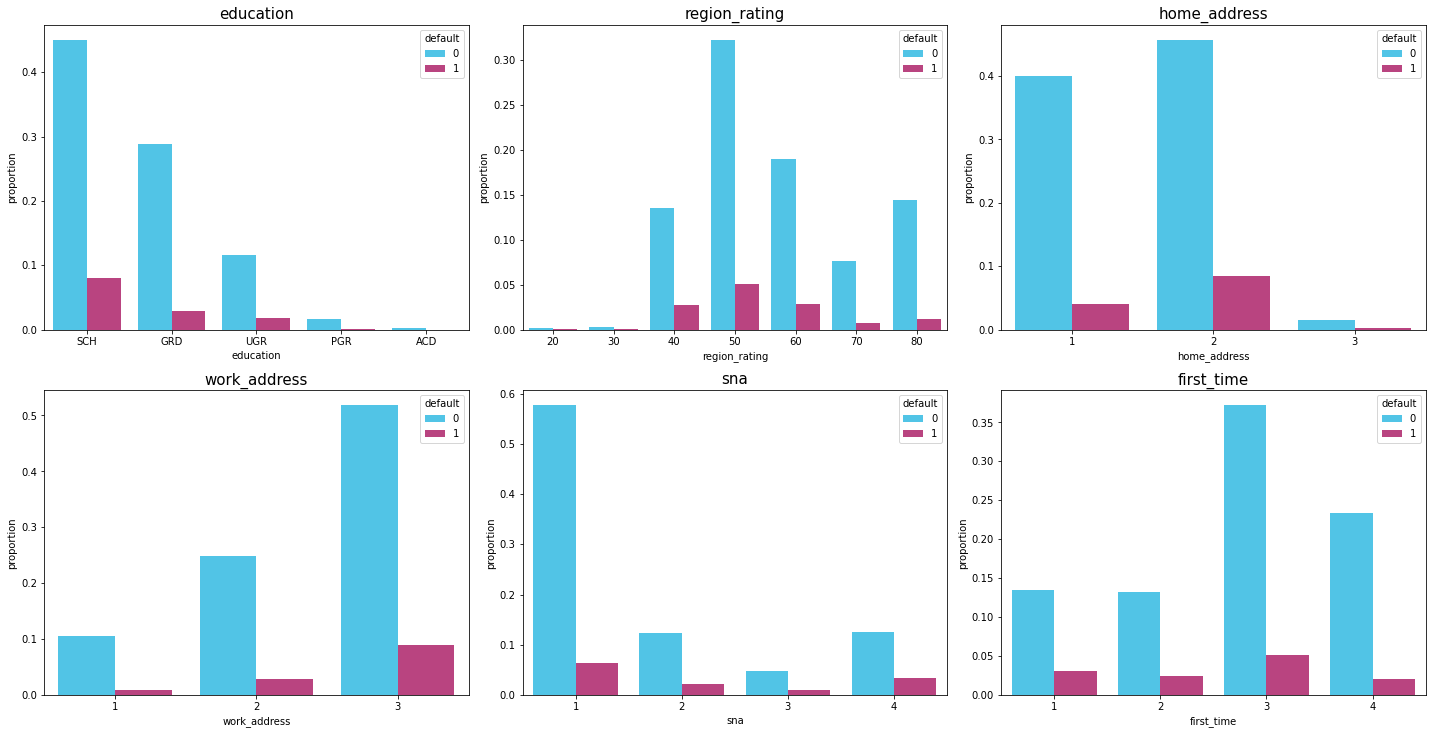

In [290]:
plt.figure(figsize=[20, 20])
i = 1

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k,
                y='proportion',
                hue='default',
                data=train[[k, 'default']].value_counts(
                    normalize=True).rename('proportion').reset_index(),
                palette=[colors[3], colors[4]])
    plt.title(k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

In [291]:
for i in cat_cols:
    print(round(train.groupby([i]).default.value_counts(normalize=True),3))
    print()

education  default
ACD        0          0.959
           1          0.041
GRD        0          0.910
           1          0.090
PGR        0          0.936
           1          0.064
SCH        0          0.850
           1          0.150
UGR        0          0.868
           1          0.132
Name: default, dtype: float64

region_rating  default
20             0          0.786
               1          0.214
30             0          0.810
               1          0.190
40             0          0.830
               1          0.170
50             0          0.864
               1          0.136
60             0          0.871
               1          0.129
70             0          0.908
               1          0.092
80             0          0.927
               1          0.073
Name: default, dtype: float64

home_address  default
1             0          0.907
              1          0.093
2             0          0.845
              1          0.155
3             0       

* Образование влияет на надёжность клиента, возможно есть смысл перевести признак в числовую категорию
* Так же, чем выше рейтинг региона, тем ниже вероятность дефолта
* Домашний и рабочий адреса из категории 1 реже попадают в дефолт, однако 2 и 3 ведут себя по-разному. (Хотя и распределение по категориям 1, 2 или 3 у этих признаков разное. Высокая корреляция, необходимо будет обработать эти 2 признака.
* Чем выше показатель sna, тем выше вероятность дефолта
* Чем дольше имеется информация о заёмщике, тем ниже вероятность дефолта

Rank of Matrix: 5
Determinant of matrix: 0.3067
Shape of matrix: (5, 5)


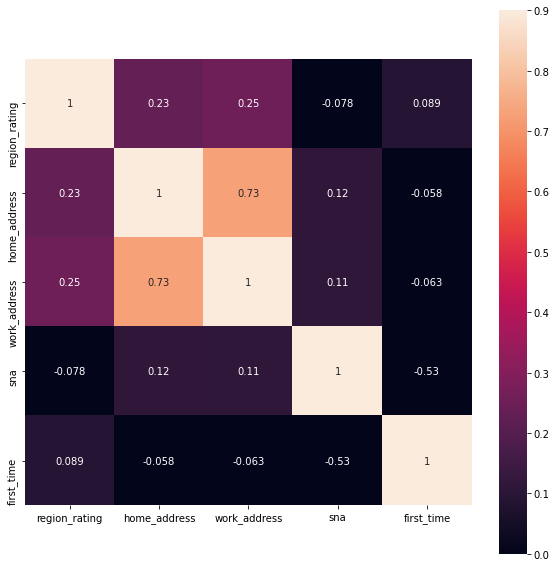

In [292]:
corr_matrix(train[cat_cols])

* сильная корреляция между work_address и home_address
* также эти два признака немного коррелируют с region_rating

**Дата**

Есть данные только по 4 месяцам. Выведем колонку с месяцем отдельно.

In [293]:
train['month'] = train.app_date.dt.month

In [294]:
# weekday
train['weekday'] = train.app_date.dt.weekday

<AxesSubplot:>

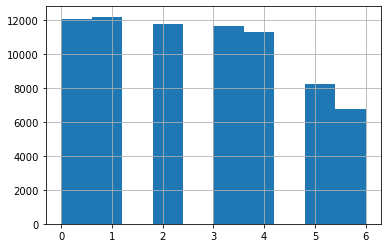

In [295]:
train.weekday.hist()

In [296]:
train.weekday.value_counts(normalize=True)

1    0.164989
0    0.162929
2    0.159081
3    0.157387
4    0.152617
5    0.111533
6    0.091465
Name: weekday, dtype: float64

Чаще заявку подают по будням, реже по выходным. Можем разделить на 3 категории - выходные, первая часть недели(пон-вт), вторая часть недели(срд-пт). Не знаю зачем, но вдруг что-то покажет

In [297]:
train['weekpart'] = train.weekday.apply(lambda x: 0 if x<2 else (1 if (2<=x<=4) else 2))

In [298]:
train['day'] = train.app_date.dt.day

In [299]:
train.day.value_counts

<bound method IndexOpsMixin.value_counts of 0         1
1        12
2         1
3        23
4        18
         ..
73794     4
73795    24
73796    22
73797     4
73798    23
Name: day, Length: 73799, dtype: int64>

In [300]:
train['month_part'] = train.day.apply(lambda x: 0 if x<11 else (1 if (11<=x<=21) else 2))

In [301]:
train['weekends'] = train.weekday.apply(lambda x: 0 if x<5 else 1)

Проверим какой признак наиболее значимый

In [302]:
date_cols = ['month', 'day', 'weekday', 'weekpart', 'month_part']
date_cols_cat = ['weekpart', 'month_part', 'weekends']

In [303]:
for col in date_cols_cat:
    train[col] = lbl.fit_transform(train[col])

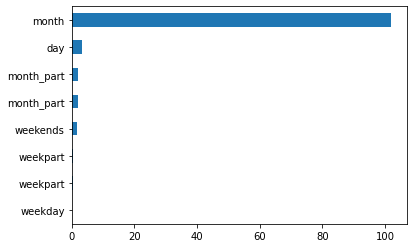

In [304]:
barh_plot(train, date_cols_cat+date_cols)

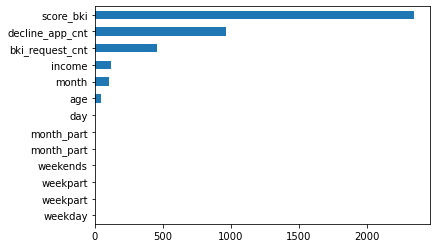

In [305]:
barh_plot(train, date_cols_cat+date_cols+num_cols)

Оставим только month, остальное уберём

In [306]:
date_cols.remove('month')

In [307]:
train = train.drop(date_cols+date_cols_cat, axis=1)

# Анализ всех признаков

In [308]:
train = encoder(train, cat_cols)

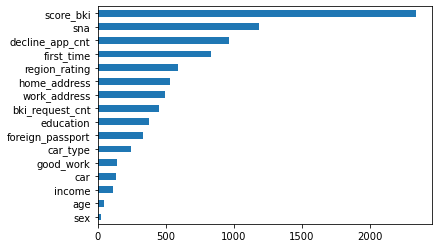

In [309]:
barh_plot(train, cat_cols+bin_cols+num_cols)

Rank of Matrix: 19
Determinant of matrix: 0.0045
Shape of matrix: (19, 19)


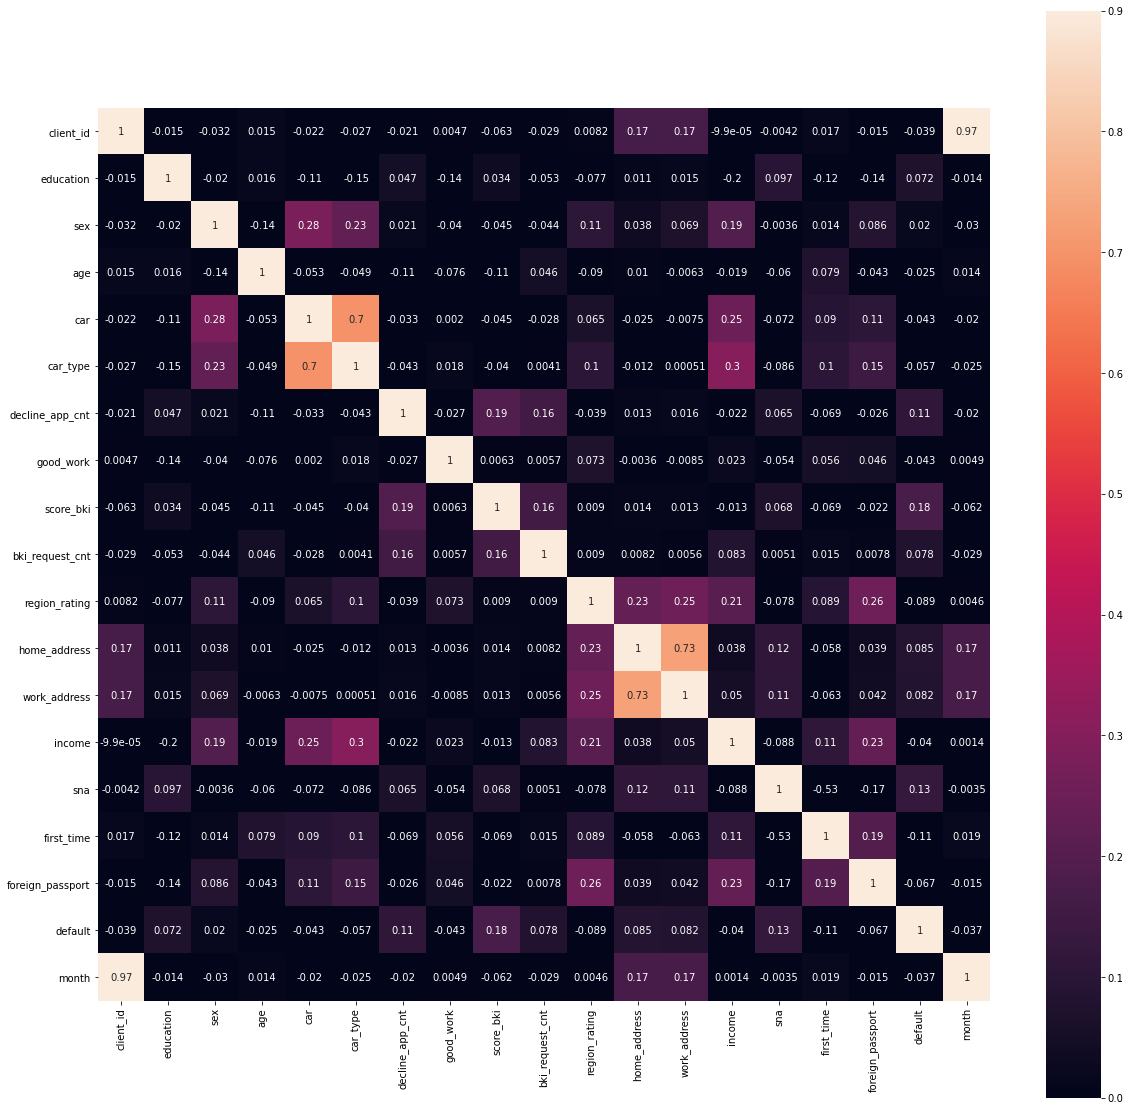

In [198]:
corr_matrix(train.drop(['sample'], axis=1), pltx=20, plty=20)

* В итоге у нас почти прямая корреляция между месяцем и ID клиента. Видимо такая система присвоения номера
* Из новых корреляцих между бинарными, категориальными и числовыми признаками бросается в глаза income и car/car_type

# Построим наивную модель

In [311]:
# Разделим обратно на train и test
#train = data.query('sample == 1').drop(['sample'], axis=1)
#test = data.query('sample == 0').drop(['sample'], axis=1)

In [312]:
train = dummy_and_standard(train)

In [313]:
# удалим для X целевую переменную и client_id
X = train.drop(columns = ['default', 'app_date', 'sample'])
y = train['default']

In [314]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [315]:
model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [316]:
y_pred = model.predict(X_val)

In [317]:
y_pred2 = model.predict(X_train)

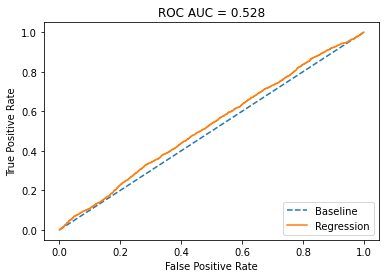

In [318]:
make_roc_auc(model, X_val, y_val)

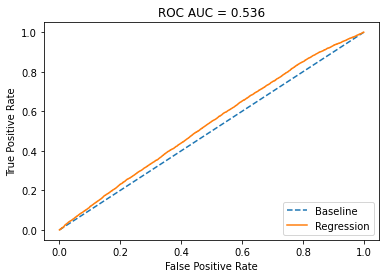

In [319]:
make_roc_auc(model, X_train, y_train)

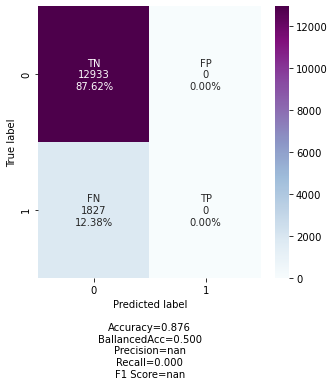

In [320]:
cf = confusion_matrix(y_val, y_pred)
make_confusion_matrix(cf)

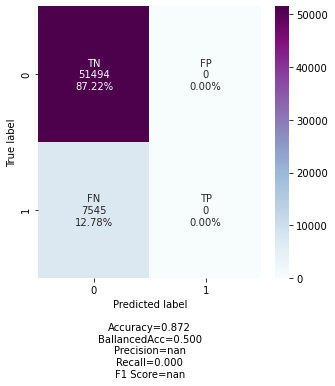

In [321]:
cf2 = confusion_matrix(y_train, y_pred2)
make_confusion_matrix(cf2)

Модель, по сути, умеет только не давать кредиты. На новых данных она вряд ли покажет хорошие результаты. Судя по всему, в выборке не сбалансирована метрика дефолта, что и приводит к ложно-высокому показателю на этих данных

In [322]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [323]:
cv_metrics = cross_validate(model, X, y, cv=5, scoring='f1_micro', return_train_score=True)

[train] F1-score = 0.87 +/- 0.00
[valid] F1-score = 0.87 +/- 0.00


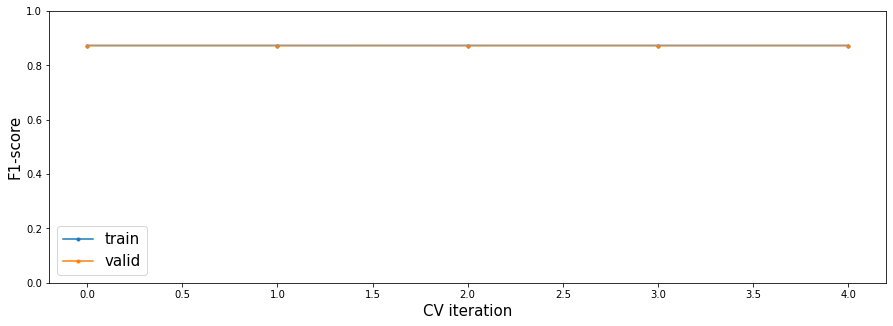

In [324]:
plot_cv_metrics(cv_metrics)


# Feature Engineering

Завернул всё в функции

In [325]:
data = prepare_data(data)
data = feat_eng(data)

**car_combined**

car_combined = car + car_type 

0 - нет машины, 1 - есть машина, 2 - есть иномарка

**age_cat**

young (<25), adult(25-35), middle(35-50), senior(50+)

**address**

work_address, home_address

объединил признаки с помощью метода главных компонент (pca)

In [326]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  object 
 2   sex               110148 non-null  object 
 3   decline_app_cnt   110148 non-null  int64  
 4   good_work         110148 non-null  int64  
 5   score_bki         110148 non-null  float64
 6   bki_request_cnt   110148 non-null  int64  
 7   region_rating     110148 non-null  int64  
 8   income            110148 non-null  int64  
 9   sna               110148 non-null  int64  
 10  first_time        110148 non-null  int64  
 11  foreign_passport  110148 non-null  object 
 12  default           110148 non-null  int64  
 13  sample            110148 non-null  int64  
 14  month             110148 non-null  int64  
 15  car_combined      110148 non-null  object 
 16  age_cat           11

# Logarythm

<AxesSubplot:>

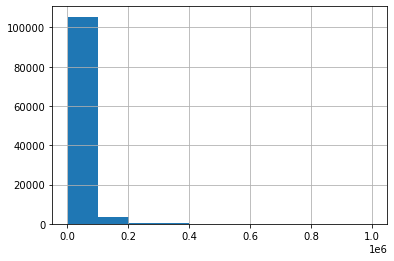

In [327]:
data.income.hist()

In [328]:
data['income'] = data['income'].apply(lambda x: np.log(x))

<AxesSubplot:>

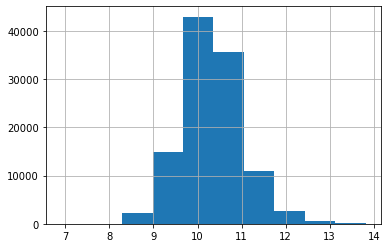

In [329]:
data.income.hist()

In [330]:
num_cols.remove('income')

После экспериментов с несколькими признаками, решил прологарифмировать только income

Rank of Matrix: 13
Determinant of matrix: 0.0064
Shape of matrix: (13, 13)


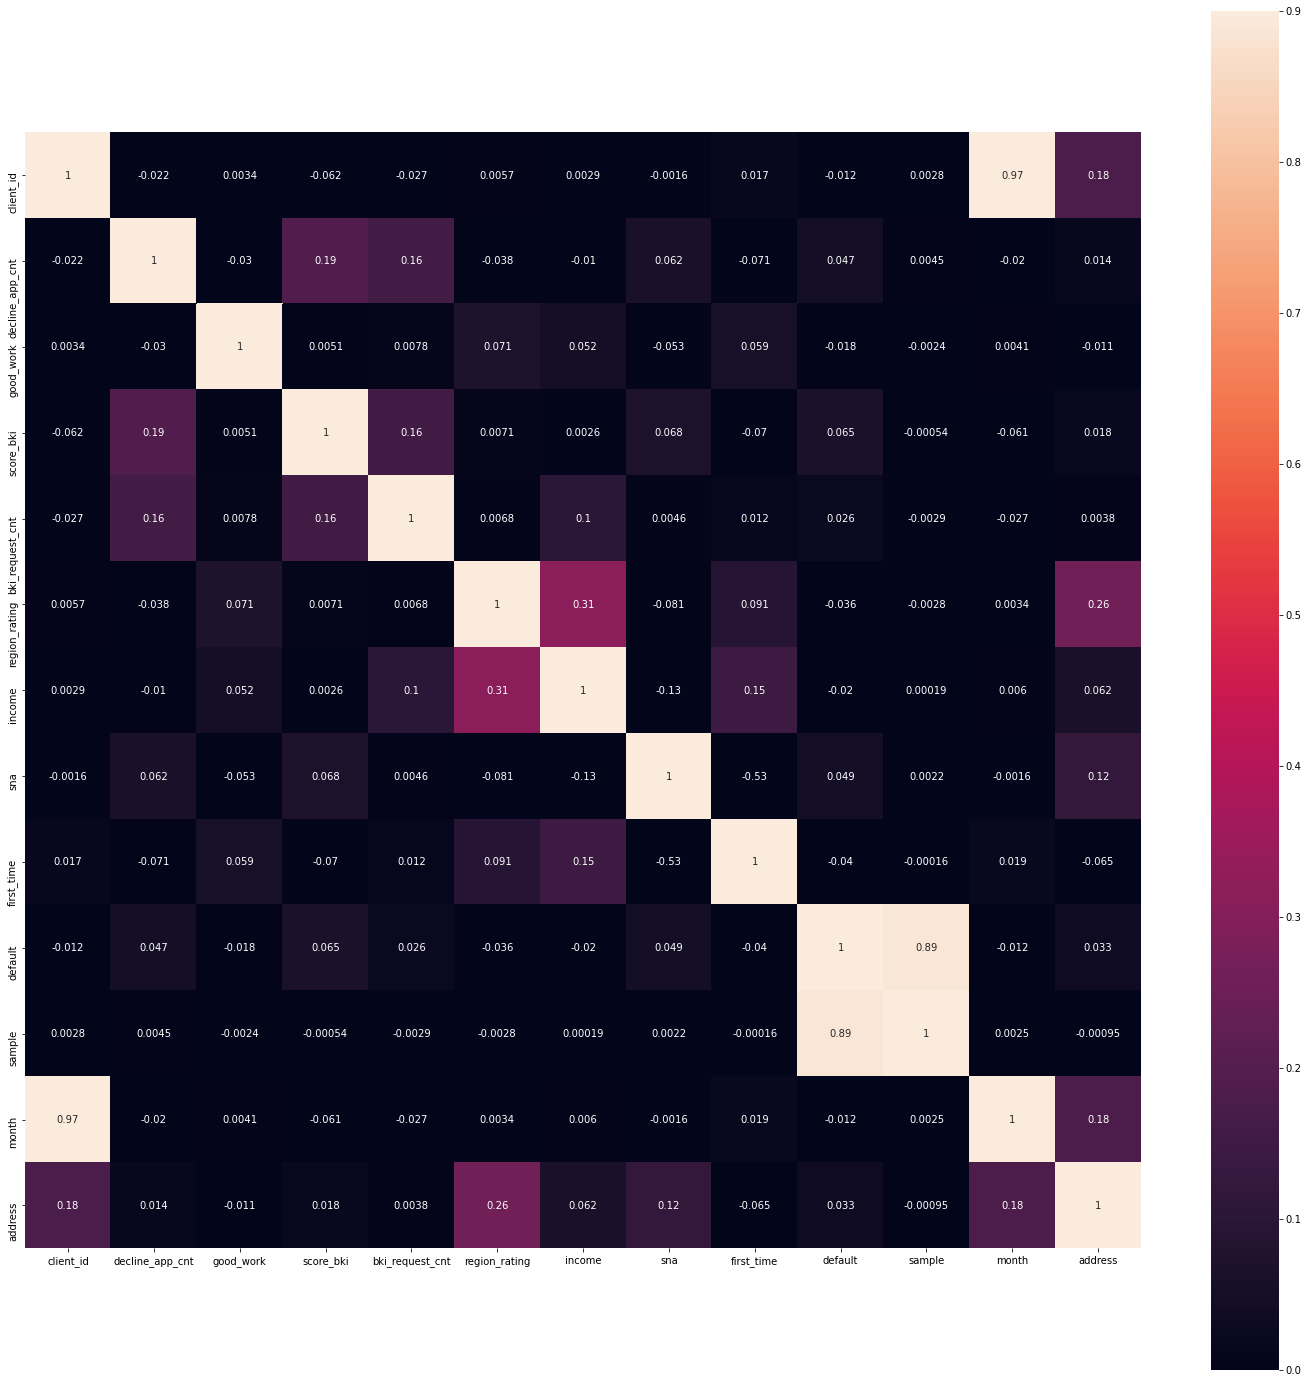

In [219]:
corr_matrix(data, pltx=25, plty=25)

# Модели

In [331]:
# df для результатов
report_df = pd.DataFrame(columns=['model', 'roc_auc', 'f1_score'])

**"Наивная" Логистическая регрессия**

In [332]:
cols_to_drop = ['sna_3', 'first_time_3', 'region_rating_6']

In [333]:
# Разделим обратно на train и valid
train = data.query('sample == 1').drop(['sample'], axis=1)
valid = data.query('sample == 0').drop(['sample'], axis=1)

# по совету из slack сначала разделяем на train и valid, потом уже стандартизируем, добавляем новые признаки
train = dummy_and_standard(train)
valid = dummy_and_standard(valid)
train = train.drop(cols_to_drop, axis=1)
valid = valid.drop(cols_to_drop, axis=1)

X = train.drop(['default'], axis=1)
y = train[['default']]

X_valid = valid.drop(['default'], axis=1)

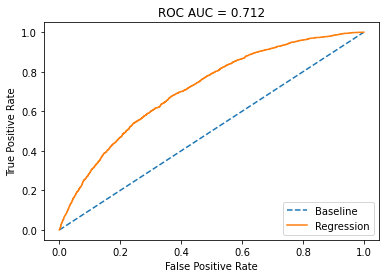

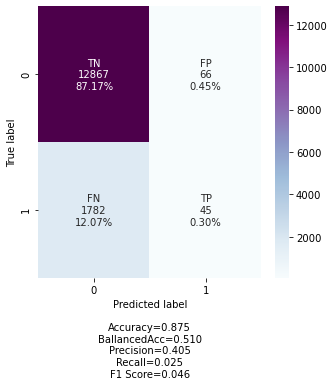

In [334]:
model, y_pred = run_log_r(X, y)

Толком ничего не поменялось, попробуем выравнять кол-во defaul в выборке.

*Подьерём параметры*

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.2)

In [336]:
## from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 25)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


*Модель с новыми параметрами*

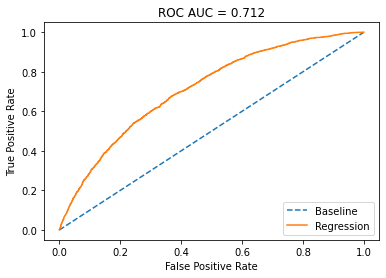

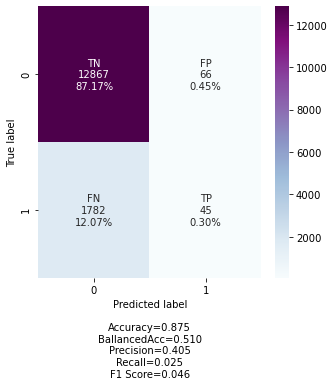

In [337]:
new_model, new_y_pred = run_log_r(X, y, penalty='l2', C=21.544346900318832)

In [338]:
report_df = fill_report('LogReg naive', new_model, X, y)

**Undersampling**

In [347]:
minority = train.default.value_counts()[1]

In [348]:
major_train = train[train.default == 0].sample(minority)
minor_train = train[train.default == 1]

In [349]:
under_train = pd.concat([major_train, minor_train])

In [350]:
under_train.default.value_counts()

0    9372
1    9372
Name: default, dtype: int64

In [351]:
X_under = under_train.drop(['default'], axis=1)
y_under = under_train[['default']]

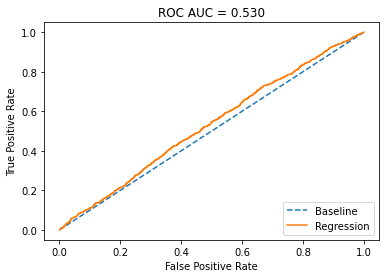

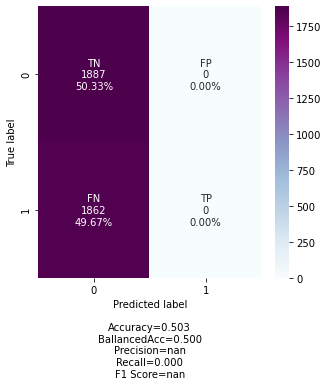

In [352]:
model_under, y_pred_under = run_log_r(X_under, y_under)

ROC AUC не изменился, но по confusion matrix мы видим, что модель ведёт себя намного лучше.
f1_score увеличился с 0.05 до 0.678

In [353]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X_under, y_under, random_state=RANDOM_SEED, test_size=0.2)

In [359]:
## from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0.001, 10, 35)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model_under = LogisticRegression()
model_under.fit(X_train_un, y_train_un)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model_under, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train_un, y_train_un)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0023052380778996


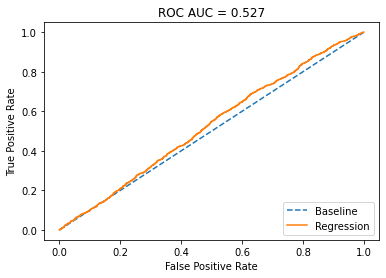

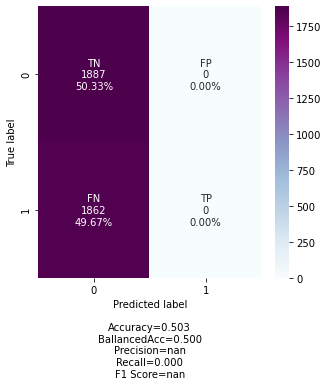

In [236]:
best_model_under, best_y_pred_under = run_log_r(X_under, y_under, penalty='l2', C=387.4675120456132)

Ничего не поменялось, микроизменения в confusion matrix

In [360]:
report_df = fill_report('LogReg UnderSampling', model_under, X_under, y_under)

[train] F1-score = 0.50 +/- 0.00
[valid] F1-score = 0.50 +/- 0.00


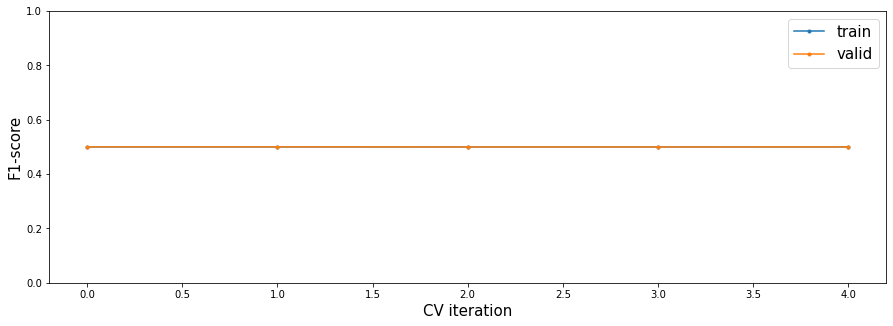

In [361]:
cv_metrics = cross_validate(model, X_under, y_under, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)


Переобучения/недообучения тоже нет

**Oversampling**

In [362]:
oversample = RandomOverSampler(sampling_strategy=1)
X_over, y_over = oversample.fit_resample(X, y)

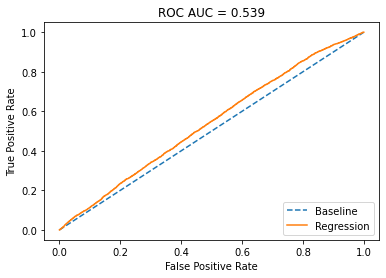

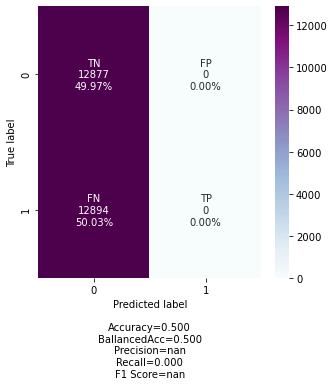

In [363]:
model_over, y_pred_over = run_log_r(X_over, y_over)

In [364]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_over, y_over, random_state=RANDOM_SEED, test_size=0.2)
## from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0.001, 10, 15)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model_over = LogisticRegression()
model_over.fit(X_train_ov, y_train_ov)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model_over, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train_ov, y_train_ov)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0023052380778996


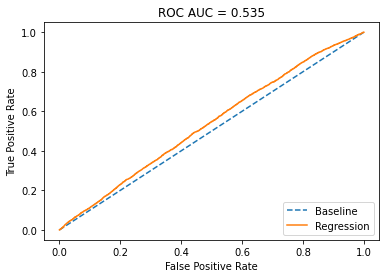

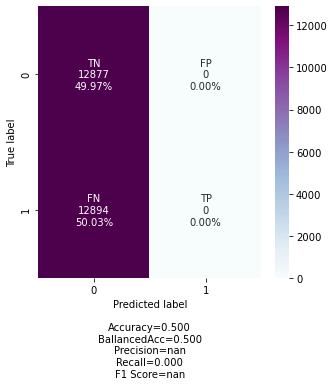

In [242]:
model_over, y_pred_over = run_log_r(X_over, y_over, penalty='l2', C=26.879957110743135)

In [365]:
report_df = fill_report('LogReg OverSampling', model_over, X_over, y_over)

[train] F1-score = 0.50 +/- 0.00
[valid] F1-score = 0.50 +/- 0.00


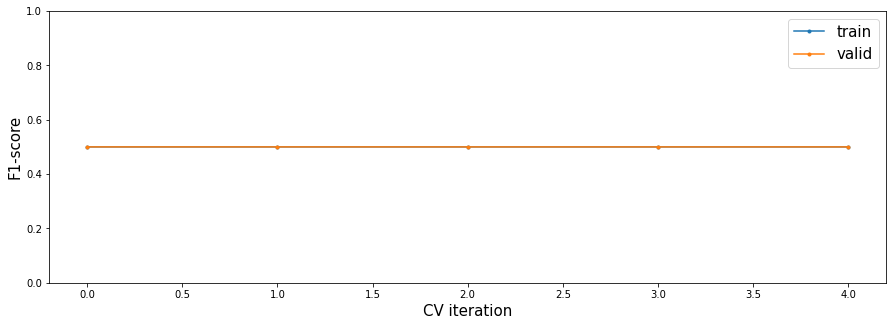

In [366]:
cv_metrics = cross_validate(model_over, X_over, y_over, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

Есть ощутимая разница между oversampling и undersampling в плане roc auc, однако всё равно стоит проверить как модель поведёт себя на тестовых данных 

**RandomForest**

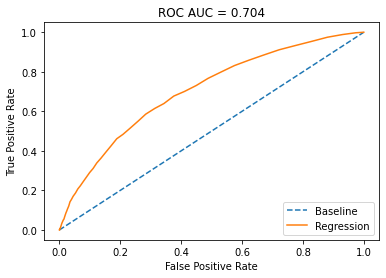

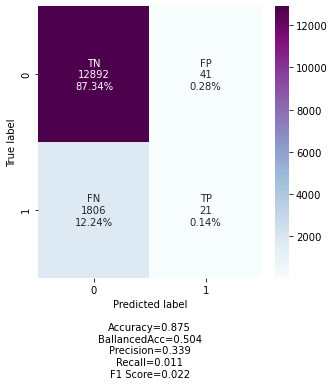

In [367]:
model_randf, y_pred_randf = run_rand_forest(X, y)

Просто решил попробовать RandomForestClassifier. На наивной модели показатель ниже, чем y LogReg

In [246]:
# Grid Search
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=42)

param = {
    'bootstrap': [True],
    'max_depth': [5, 15],
    'n_estimators': [1000, 1500]
}

clf_rf = GridSearchCV(rf_skf,
                      param,
                      scoring='roc_auc',
                      refit=True,
                      cv=skf,
                      verbose=3,
                      n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_rf_skf = clf_rf.predict(X_test)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf.best_score_,
                                                    clf_rf.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best roc_auc: 0.7151, with best C: {'bootstrap': True, 'max_depth': 5, 'n_estimators': 1000}


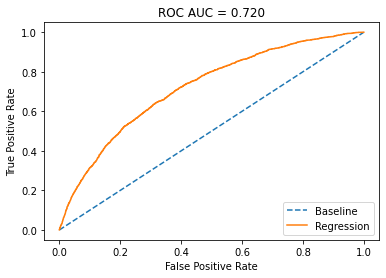

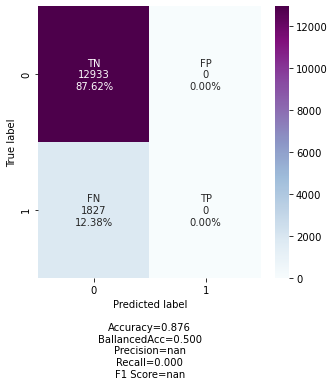

In [247]:
best_model_randf, best_y_pred_randf = run_rand_forest(X, y, n_estimators=1500, max_depth=5)

После подкручивания параметров (что занимает намного больше времени, чем у LogReg) модель тоже научилась не выдавать кредиты.

In [248]:
report_df = fill_report('RandForest Naive', best_model_randf, X, y)

**Undersampling**

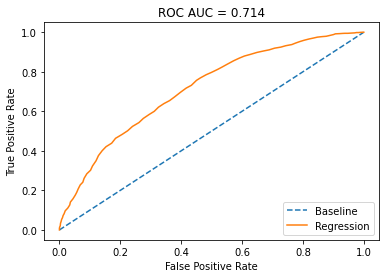

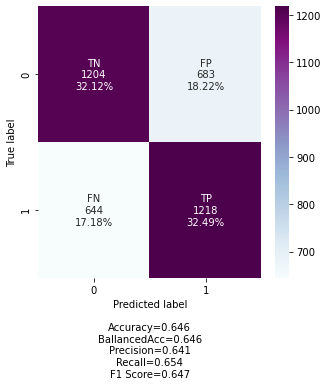

In [249]:
model_randf_under, y_pred_randf_under = run_rand_forest(X_under, y_under)

In [250]:
# Grid Search
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=42)

param = {
    'bootstrap': [True],
    'max_depth': [5, 10],
    'n_estimators': [400, 600]
}

clf_rf_under = GridSearchCV(rf_skf,
                      param,
                      scoring='roc_auc',
                      refit=True,
                      cv=skf,
                      verbose=3,
                      n_jobs=-1)
clf_rf_under.fit(X_train, y_train)

y_pred_rf_skf_under = clf_rf_under.predict(X_test_un)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_rf_under.best_score_,
                                                    clf_rf_under.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best roc_auc: 0.7218, with best C: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 600}


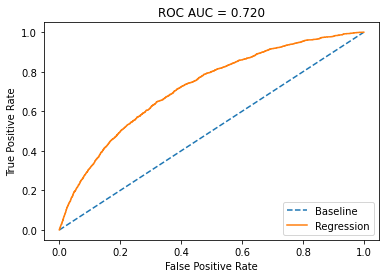

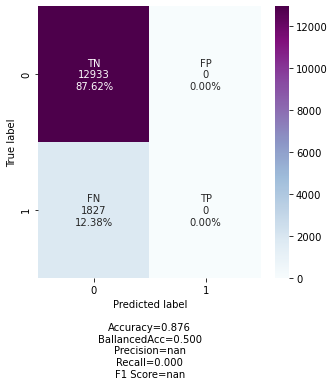

In [251]:
best_model_randf_un, best_y_pred_randf_un = run_rand_forest(X, y, n_estimators=500, max_depth=5)

Нуу, чего-то не особо получается с RandomForest, и надо каждый раз очень долго ждать, чтобы подобрать какие-то параметры

In [252]:
report_df = fill_report('RandForest UnderSampling', best_model_randf_un, X, y)

**Oversampling**

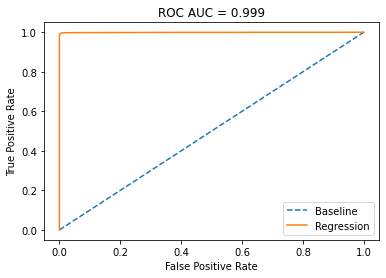

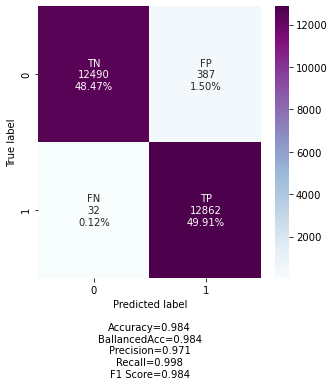

In [253]:
model_randf_over, y_pred_randf_over = run_rand_forest(X_over, y_over)

[train] F1-score = 1.00 +/- 0.00
[valid] F1-score = 0.98 +/- 0.00


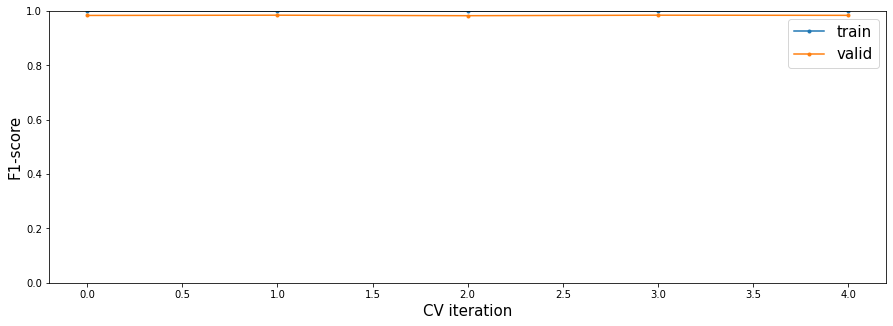

In [254]:
cv_metrics = cross_validate(model_randf_over, X_over, y_over, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

Ну всё, я прошёл эту модель

***P.S Можно узнать почему такое вышло? Не совсем понимаю как это трактовать***

# Выводы по моделям

В итоге, хоть я и не применял большое кол-во разных моделей, да и настройка параметров в логистической регрессии не оказывало практически никакого эффекта, но самую большую эффективность показала **Undersampling LogReg**

In [255]:
report_df

model   roc_auc  f1_score
0              LogReg naive  0.711910   0.04644
0      LogReg UnderSampling  0.526578   0.00000
0       LogReg OverSampling  0.535453   0.00000
0          RandForest Naive  0.720276   0.00000
0  RandForest UnderSampling  0.720171   0.00000

# Submission

In [256]:
id = test['client_id']

submission = pd.DataFrame({'client_id': id,
                           'default': model_under.predict_proba(X_valid)[:, 1]})
submission.to_csv('submission.csv', index=False)

In [257]:
submission

client_id   default
0          74835  0.482898
1          17527  0.495993
2          75683  0.482704
3          26883  0.493854
4          28862  0.493402
...          ...       ...
36344      83775  0.480856
36345     106254  0.475727
36346      81852  0.481295
36347       1971  0.499549
36348      69044  0.484220

[36349 rows x 2 columns]